I'm protyping some RL models in this notebook

Homero

## TD Models

TD-learning family models:
1. <a href='#oneStepTD'> TD(0) </a>
2. Actor-critic:
    * Some Theory: <a href='http://incompleteideas.net/book/first/ebook/node66.html'>Actor-Critic Methods</a>
    * Possible Implementation: <a href='https://www.nature.com/articles/s41598-017-18004-7'> A hippocampo-cerebellar centred network for the learning and execution of sequence-based navigation </a>

In [1]:
# Imports
from __future__ import print_function
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.collections import LineCollection
from matplotlib import cm
from copy import deepcopy
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys

module_path = 'src' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *
from model_plot_utils import plot_trajectory

import parameters

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Defining global variables

# Some lists of nicknames for mice
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

# Define cell numbers of end/leaf nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}
quad1 = [3,7,8,15,16,17,18,31,32,33,34,35,36,37,38,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78]
quad2 = [4,9,10,19,20,21,22,39,40,41,42,43,44,45,46,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94]
quad3 = [5,11,12,23,24,25,26]
quad3.extend(list(range(47,54)))
quad3.extend(list(range(95,110)))
quad4 = [6,13,14,27,28,29,30]
quad4.extend(list(range(55,62)))
quad4.extend(list(range(111,126)))

# Parameters for simulating new trajectories
InvalidState = -1
RewardNode = 116
HomeNode = 127
StartNode = 0
S = 128  # Number of states
A = 3
RewardNodeMag = 1
main_dir = 'stan/'
real_traj_dir = main_dir+'traj_data/real_traj/'
pred_traj_dir = main_dir+'traj_data/pred_traj/'
stan_results_dir = main_dir+'stan_results/'
# nodemap = pickle.load(open('stan/nodemap.p', 'rb'))

In [3]:
"""
Use this base class to define your model: from extracting data to loading states
and actions, to simulating agents.
This is supposed to be only provide a skeleton, feel free to override any
function.
For an example, refer to TDLambdaXStepsRewardReceived file that inherits from
this class.
"""

import abc
import os
import numpy as np
import pickle
from pathlib import Path

from parameters import *
WaterPortNode = 128



class BaseModel:
    def __init__(self, file_suffix='BaseModel'):
        self.S = 129  # Number of states, including WaterPortState
        self.A = 3    # Number of max actions for a state
        self.file_suffix = file_suffix

    def extract_trajectory_data(self, save_dir=None):
        """
        Extracts the required trajectory data and pickle-dumps on the disk.
        """
        pass

    def load_data(self, main_dir):
        self.main_dir = os.path.abspath(main_dir)
        self.stan_data_dir = os.path.join(self.main_dir, 'pre_reward_traj/real_traj')
        Path(self.stan_data_dir).mkdir(parents=True, exist_ok=True)

    def get_SAnodemap(self):
        """
        Creates a mapping based on the maze layout where current states are linked to the next 3 future states
        Returns: SAnodemap, a 2D array of current state to future state mappings
                 Also saves SAnodemap in the main_dir as 'nodemap.p'
        Return type: ndarray[(S, A), int]
        """
        SAnodemap = np.ones((self.S, self.A), dtype=int) * InvalidState
        for node in np.arange(self.S-1):
            # Shallow level node available from current node
            if node%2 == 0:
                SAnodemap[node,0] = (node - 2) / 2
            elif node%2 == 1:
                SAnodemap[node,0] = (node - 1) / 2
            if SAnodemap[node,0] == InvalidState:
                SAnodemap[node,0] = HomeNode

            if node not in lv6_nodes:
                # Deeper level nodes available from current node
                SAnodemap[node,1] = node*2 + 1
                SAnodemap[node,2] = node*2 + 2

        # Nodes available from entry point
        SAnodemap[HomeNode,0] = InvalidState
        SAnodemap[HomeNode,1] = 0
        SAnodemap[HomeNode,2] = InvalidState

        # Nodes at WaterPortState
        SAnodemap[WaterPortNode, 0] = InvalidState
        SAnodemap[WaterPortNode, 1] = InvalidState
        SAnodemap[WaterPortNode, 2] = InvalidState
        return SAnodemap

    @staticmethod
    def __load_trajectories__(data):
        # TrajS   : 3D matrix of (number of mice, number of bouts, number of steps in each bout)

        N = len(data)
        B = max([len(n) for n in data])
        BL = max([len(b) for n in data for b in n])

        TrajS = np.ones((N, B, BL)) * InvalidState

        # over mouse
        for n in np.arange(len(data)):
            # over each of their bouts
            for b in np.arange(len(data[n])):
                # over each step of the bout
                for s in np.arange(len(data[n][b])):
                    TrajS[n, b, s] = data[n][b][s]
        return TrajS.astype(int)

    def load_trajectories_from_file(self, data_file):
        with open(data_file, 'rb') as f:
            data = pickle.load(f)
        return self.__load_trajectories__(data)

    def load_trajectories_from_object(self, trajectory_data):
        return self.__load_trajectories__(trajectory_data)

    def load_TrajA(self, TrajS, nodemap):
        # TrajA   : 3D matrix of (number of mice, number of bouts, number of steps in each bout)
        # TrajA   : Matrix entries are action indices (1, 2 or 3) taken to transition from t to t+1 in TrajS
        #           extra space in the matrix is filled with an invalid action, 0.
        #           Action values of 1 is a transition from a deep node, s to shallow node sprime
        #           Action values 2 and 3 are transitions from a shallow node, s to deeper nodes, sprime
        N, B, BL = TrajS.shape
        TrajA = np.zeros((N, B, BL)).astype(int)
        for n in np.arange(N):
            for b in np.arange(B):
                for bl in np.arange(BL - 1):
                    if TrajS[n, b, bl + 1] == InvalidState or TrajS[n, b, bl + 1] == WaterPortNode:
                        break
                    TrajA[n, b, bl] = np.where(
                        nodemap[TrajS[n, b, bl], :] == TrajS[n, b, bl + 1]
                    )[0][0] + 1
        return TrajA

    def simulate(self, sub_fits):
        """
        Simulate the agent with given set of parameters sub_fits.
        """
        pass

In [4]:
def visualize_pred(avg_V, state_hist_all, save_dir=None):
    '''
    avg_V: vector of state values averaged across multiple runs of the model
           ndarray[(1,S), float]
    state_hist_all: dictionary of trajectories simulated by a model. Eg. state_hist_all{0:[0,1,3..], 1:[]..}
    
    Returns: A heatmap of state values and predicted trajectories plotted on the maze layout
    '''
    # Plotting state values
    fig, ax = plt.subplots(figsize=(10,3))
#     axhandle = ax.imshow(np.transpose(np.reshape(avg_V,(S,1))),cmap='YlGnBu')
    plt.pcolor(np.transpose(np.reshape(avg_V,(S,1))),cmap='YlGnBu')
    plt.colorbar()
    ax.invert_yaxis()
    ax.set_ylabel('V (s)')
    ax.set_xticks(np.arange(0,127,5))
    ax.set_xticklabels([str(val) for val in np.arange(0,127,5)])
    ax.set_xlabel('Nodes')
    ax.set_title('Average state values for TD(0) with alpha: %.2f, beta: %.2f and gamma: %.2f' %(alpha,beta,gamma))
#     fig.colorbar(axhandle,fraction=0.005)

    print('Max state value ', np.max(avg_V))
    print('Min state value', np.min(avg_V))

    # Plot predicted trajectories
    plot_trajectory(state_hist_all, 'all', save_dir=None)

In [5]:
def softmax(s, V, beta):
    '''
    Selects an action (either 0, 1 or 2) to take from current state, s using the current set of state-values and beta parameter.
    :param V: state-values for all nodes, ndarray[S, float]
    :param beta: fixed or fitted inverse temperature parameter, beta
    :return:
    '''

    if s == RewardNode or s == HomeNode:
        prob = [0,1,0]
        a = 1
    elif InvalidState in nodemap[s, :]:
        prob = [1,0,0]
        a = 0  # If the current state is an end node, a = 0 will make a transition to level 5 node
    else:
        softmaxEXP = []
        next_options = nodemap[s, :]
        for node in next_options:
            softmaxEXP.extend([np.exp(beta * V[node])])
        prob = softmaxEXP / np.sum(softmaxEXP)
        try:
            a = np.random.choice([0, 1, 2], 1, p=prob)[0]
        except:
            a = InvalidState
            print('Error with probabilities. softmaxEXP: ', softmaxEXP, ' nodes: ', nodemap[s, :], ' state-values: ', V[nodemap[s, :]])

    return a, prob

### TD(0) <a id='#oneStepTD'></a>
Online TD-control algorithm which estimates state values, V(s)
 - States: 128 maze nodes (including home node)
 - Terminal states: maze entry, 127 and reward port, 116
 - Rewards: 0 on all states except for 1 on the water port
 
 Pseudocode
- Softmax action selection policy: $\pi(a | s_i) = \frac{e^{\beta*V(s_{ij})}}{e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})}}$, where j indexes the 3 neighboring nodes to $s_i$
- State-value update: $V(s) \leftarrow V(s) + \alpha*(R + \gamma*V(s') - V(s))$

 Re-parametrized version where $\beta = \beta * \alpha$ and $V(s) = \frac{V(s)}{\alpha}$
- original action-value update: $V(s) \leftarrow (1-\alpha)V(s) + \alpha(R + \gamma * V(s'))$
- new action-value update: $V(s) \leftarrow (1-\alpha)V(s) + R + \alpha * \gamma * V(s')$

0
1
2
3
4
100
action  0 state  6
200
action  0 state  -1
300
action  0 state  -1
400
action  0 state  -1
500
action  0 state  -1
600
action  0 state  -1
700
action  0 state  -1
800
action  0 state  -1
900
action  0 state  -1
1000
action  0 state  -1
1100
action  0 state  -1
1200
action  0 state  -1
1300
action  0 state  -1
1400
action  0 state  -1
1500
action  0 state  -1
1600
action  0 state  -1
1700
action  0 state  -1
1800
action  0 state  -1
1900
action  0 state  -1
2000
action  0 state  -1
2100
action  0 state  -1
2200
action  0 state  -1
2300
action  0 state  -1
2400
action  0 state  -1
2500
action  0 state  -1
2600
action  0 state  -1
2700
action  0 state  -1
2800
action  0 state  -1
2900
action  0 state  -1
3000
action  0 state  -1
3100
action  0 state  -1
3200
action  0 state  -1
3300
action  0 state  -1
3400
action  0 state  -1
3500
action  0 state  -1
3600
action  0 state  -1
3700
action  0 state  -1
3800
action  0 state  -1
3900
action  0 state  -1
4000
action  0 state  -1


action  0 state  -1
32500
action  0 state  -1
32600
action  0 state  -1
32700
action  0 state  -1
32800
action  0 state  -1
32900
action  0 state  -1
33000
action  0 state  -1
33100
action  0 state  -1
33200
action  0 state  -1
33300
action  0 state  -1
33400
action  0 state  -1
33500
action  0 state  -1
33600
action  0 state  -1
33700
action  0 state  -1
33800
action  0 state  -1
33900
action  0 state  -1
34000
action  0 state  -1
34100
action  0 state  -1
34200
action  0 state  -1
34300
action  0 state  -1
34400
action  0 state  -1
34500
action  0 state  -1
34600
action  0 state  -1
34700
action  0 state  -1
34800
action  0 state  -1
34900
action  0 state  -1
35000
action  0 state  -1
35100
action  0 state  -1
35200
action  0 state  -1
35300
action  0 state  -1
35400
action  0 state  -1
35500
action  0 state  -1
35600
action  0 state  -1
35700
action  0 state  -1
35800
action  0 state  -1
35900
action  0 state  -1
36000
action  0 state  -1
36100
action  0 state  -1
36200
action  0 st

action  0 state  -1
72300
action  0 state  -1
72400
action  0 state  -1
72500
action  0 state  -1
72600
action  0 state  -1
72700
action  0 state  -1
72800
action  0 state  -1
72900
action  0 state  -1
73000
action  0 state  -1
73100
action  0 state  -1
73200
action  0 state  -1
73300
action  0 state  -1
73400
action  0 state  -1
73500
action  0 state  -1
73600
action  0 state  -1
73700
action  0 state  -1
73800
action  0 state  -1
73900
action  0 state  -1
74000
action  0 state  -1
74100
action  0 state  -1
74200
action  0 state  -1
74300
action  0 state  -1
74400
action  0 state  -1
74500
action  0 state  -1
74600
action  0 state  -1
74700
action  0 state  -1
74800
action  0 state  -1
74900
action  0 state  -1
75000
action  0 state  -1
75100
action  0 state  -1
75200
action  0 state  -1
75300
action  0 state  -1
75400
action  0 state  -1
75500
action  0 state  -1
75600
action  0 state  -1
75700
action  0 state  -1
75800
action  0 state  -1
75900
action  0 state  -1
76000
action  0 st

action  0 state  -1
107400
action  0 state  -1
107500
action  0 state  -1
107600
action  0 state  -1
107700
action  0 state  -1
107800
action  0 state  -1
107900
action  0 state  -1
108000
action  0 state  -1
108100
action  0 state  -1
108200
action  0 state  -1
108300
action  0 state  -1
108400
action  0 state  -1
108500
action  0 state  -1
108600
action  0 state  -1
108700
action  0 state  -1
108800
action  0 state  -1
108900
action  0 state  -1
109000
action  0 state  -1
109100
action  0 state  -1
109200
action  0 state  -1
109300
action  0 state  -1
109400
action  0 state  -1
109500
action  0 state  -1
109600
action  0 state  -1
109700
action  0 state  -1
109800
action  0 state  -1
109900
action  0 state  -1
110000
action  0 state  -1
110100
action  0 state  -1
110200
action  0 state  -1
110300
action  0 state  -1
110400
action  0 state  -1
110500
action  0 state  -1
110600
action  0 state  -1
110700
action  0 state  -1
110800
action  0 state  -1
110900
action  0 state  -1
111000
a

action  0 state  -1
144400
action  0 state  -1
144500
action  0 state  -1
144600
action  0 state  -1
144700
action  0 state  -1
144800
action  0 state  -1
144900
action  0 state  -1
145000
action  0 state  -1
145100
action  0 state  -1
145200
action  0 state  -1
145300
action  0 state  -1
145400
action  0 state  -1
145500
action  0 state  -1
145600
action  0 state  -1
145700
action  0 state  -1
145800
action  0 state  -1
145900
action  0 state  -1
146000
action  0 state  -1
146100
action  0 state  -1
146200
action  0 state  -1
146300
action  0 state  -1
146400
action  0 state  -1
146500
action  0 state  -1
146600
action  0 state  -1
146700
action  0 state  -1
146800
action  0 state  -1
146900
action  0 state  -1
147000
action  0 state  -1
147100
action  0 state  -1
147200
action  0 state  -1
147300
action  0 state  -1
147400
action  0 state  -1
147500
action  0 state  -1
147600
action  0 state  -1
147700
action  0 state  -1
147800
action  0 state  -1
147900
action  0 state  -1
148000
a

action  0 state  -1
178700
action  0 state  -1
178800
action  0 state  -1
178900
action  0 state  -1
179000
action  0 state  -1
179100
action  0 state  -1
179200
action  0 state  -1
179300
action  0 state  -1
179400
action  0 state  -1
179500
action  0 state  -1
179600
action  0 state  -1
179700
action  0 state  -1
179800
action  0 state  -1
179900
action  0 state  -1
180000
action  0 state  -1
180100
action  0 state  -1
180200
action  0 state  -1
180300
action  0 state  -1
180400
action  0 state  -1
180500
action  0 state  -1
180600
action  0 state  -1
180700
action  0 state  -1
180800
action  0 state  -1
180900
action  0 state  -1
181000
action  0 state  -1
181100
action  0 state  -1
181200
action  0 state  -1
181300
action  0 state  -1
181400
action  0 state  -1
181500
action  0 state  -1
181600
action  0 state  -1
181700
action  0 state  -1
181800
action  0 state  -1
181900
action  0 state  -1
182000
action  0 state  -1
182100
action  0 state  -1
182200
action  0 state  -1
182300
a

action  0 state  -1
214100
action  0 state  -1
214200
action  0 state  -1
214300
action  0 state  -1
214400
action  0 state  -1
214500
action  0 state  -1
214600
action  0 state  -1
214700
action  0 state  -1
214800
action  0 state  -1
214900
action  0 state  -1
215000
action  0 state  -1
215100
action  0 state  -1
215200
action  0 state  -1
215300
action  0 state  -1
215400
action  0 state  -1
215500
action  0 state  -1
215600
action  0 state  -1
215700
action  0 state  -1
215800
action  0 state  -1
215900
action  0 state  -1
216000
action  0 state  -1
216100
action  0 state  -1
216200
action  0 state  -1
216300
action  0 state  -1
216400
action  0 state  -1
216500
action  0 state  -1
216600
action  0 state  -1
216700
action  0 state  -1
216800
action  0 state  -1
216900
action  0 state  -1
217000
action  0 state  -1
217100
action  0 state  -1
217200
action  0 state  -1
217300
action  0 state  -1
217400
action  0 state  -1
217500
action  0 state  -1
217600
action  0 state  -1
217700
a

246200
action  0 state  -1
246300
action  0 state  -1
246400
action  0 state  -1
246500
action  0 state  -1
246600
action  0 state  -1
246700
action  0 state  -1
246800
action  0 state  -1
246900
action  0 state  -1
247000
action  0 state  -1
247100
action  0 state  -1
247200
action  0 state  -1
247300
action  0 state  -1
247400
action  0 state  -1
247500
action  0 state  -1
247600
action  0 state  -1
247700
action  0 state  -1
247800
action  0 state  -1
247900
action  0 state  -1
248000
action  0 state  -1
248100
action  0 state  -1
248200
action  0 state  -1
248300
action  0 state  -1
248400
action  0 state  -1
248500
action  0 state  -1
248600
action  0 state  -1
248700
action  0 state  -1
248800
action  0 state  -1
248900
action  0 state  -1
249000
action  0 state  -1
249100
action  0 state  -1
249200
action  0 state  -1
249300
action  0 state  -1
249400
action  0 state  -1
249500
action  0 state  -1
249600
action  0 state  -1
249700
action  0 state  -1
249800
action  0 state  -1
2

action  0 state  -1
281500
action  0 state  -1
281600
action  0 state  -1
281700
action  0 state  -1
281800
action  0 state  -1
281900
action  0 state  -1
282000
action  0 state  -1
282100
action  0 state  -1
282200
action  0 state  -1
282300
action  0 state  -1
282400
action  0 state  -1
282500
action  0 state  -1
282600
action  0 state  -1
282700
action  0 state  -1
282800
action  0 state  -1
282900
action  0 state  -1
283000
action  0 state  -1
283100
action  0 state  -1
283200
action  0 state  -1
283300
action  0 state  -1
283400
action  0 state  -1
283500
action  0 state  -1
283600
action  0 state  -1
283700
action  0 state  -1
283800
action  0 state  -1
283900
action  0 state  -1
284000
action  0 state  -1
284100
action  0 state  -1
284200
action  0 state  -1
284300
action  0 state  -1
284400
action  0 state  -1
284500
action  0 state  -1
284600
action  0 state  -1
284700
action  0 state  -1
284800
action  0 state  -1
284900
action  0 state  -1
285000
action  0 state  -1
285100
a

313800
action  0 state  -1
313900
action  0 state  -1
314000
action  0 state  -1
314100
action  0 state  -1
314200
action  0 state  -1
314300
action  0 state  -1
314400
action  0 state  -1
314500
action  0 state  -1
314600
action  0 state  -1
314700
action  0 state  -1
314800
action  0 state  -1
314900
action  0 state  -1
315000
action  0 state  -1
315100
action  0 state  -1
315200
action  0 state  -1
315300
action  0 state  -1
315400
action  0 state  -1
315500
action  0 state  -1
315600
action  0 state  -1
315700
action  0 state  -1
315800
action  0 state  -1
315900
action  0 state  -1
316000
action  0 state  -1
316100
action  0 state  -1
316200
action  0 state  -1
316300
action  0 state  -1
316400
action  0 state  -1
316500
action  0 state  -1
316600
action  0 state  -1
316700
action  0 state  -1
316800
action  0 state  -1
316900
action  0 state  -1
317000
action  0 state  -1
317100
action  0 state  -1
317200
action  0 state  -1
317300
action  0 state  -1
317400
action  0 state  -1
3

action  0 state  -1
348900
action  0 state  -1
349000
action  0 state  -1
349100
action  0 state  -1
349200
action  0 state  -1
349300
action  0 state  -1
349400
action  0 state  -1
349500
action  0 state  -1
349600
action  0 state  -1
349700
action  0 state  -1
349800
action  0 state  -1
349900
action  0 state  -1
350000
action  0 state  -1
350100
action  0 state  -1
350200
action  0 state  -1
350300
action  0 state  -1
350400
action  0 state  -1
350500
action  0 state  -1
350600
action  0 state  -1
350700
action  0 state  -1
350800
action  0 state  -1
350900
action  0 state  -1
351000
action  0 state  -1
351100
action  0 state  -1
351200
action  0 state  -1
351300
action  0 state  -1
351400
action  0 state  -1
351500
action  0 state  -1
351600
action  0 state  -1
351700
action  0 state  -1
351800
action  0 state  -1
351900
action  0 state  -1
352000
action  0 state  -1
352100
action  0 state  -1
352200
action  0 state  -1
352300
action  0 state  -1
352400
action  0 state  -1
352500
a

action  0 state  -1
385100
action  0 state  -1
385200
action  0 state  -1
385300
action  0 state  -1
385400
action  0 state  -1
385500
action  0 state  -1
385600
action  0 state  -1
385700
action  0 state  -1
385800
action  0 state  -1
385900
action  0 state  -1
386000
action  0 state  -1
386100
action  0 state  -1
386200
action  0 state  -1
386300
action  0 state  -1
386400
action  0 state  -1
386500
action  0 state  -1
386600
action  0 state  -1
386700
action  0 state  -1
386800
action  0 state  -1
386900
action  0 state  -1
387000
action  0 state  -1
387100
action  0 state  -1
387200
action  0 state  -1
387300
action  0 state  -1
387400
action  0 state  -1
387500
action  0 state  -1
387600
action  0 state  -1
387700
action  0 state  -1
387800
action  0 state  -1
387900
action  0 state  -1
388000
action  0 state  -1
388100
action  0 state  -1
388200
action  0 state  -1
388300
action  0 state  -1
388400
action  0 state  -1
388500
action  0 state  -1
388600
action  0 state  -1
388700
a

420400
action  0 state  -1
420500
action  0 state  -1
420600
action  0 state  -1
420700
action  0 state  -1
420800
action  0 state  -1
420900
action  0 state  -1
421000
action  0 state  -1
421100
action  0 state  -1
421200
action  0 state  -1
421300
action  0 state  -1
421400
action  0 state  -1
421500
action  0 state  -1
421600
action  0 state  -1
421700
action  0 state  -1
421800
action  0 state  -1
421900
action  0 state  -1
422000
action  0 state  -1
422100
action  0 state  -1
422200
action  0 state  -1
422300
action  0 state  -1
422400
action  0 state  -1
422500
action  0 state  -1
422600
action  0 state  -1
422700
action  0 state  -1
422800
action  0 state  -1
422900
action  0 state  -1
423000
action  0 state  -1
423100
action  0 state  -1
423200
action  0 state  -1
423300
action  0 state  -1
423400
action  0 state  -1
423500
action  0 state  -1
423600
action  0 state  -1
423700
action  0 state  -1
423800
action  0 state  -1
423900
action  0 state  -1
424000
action  0 state  -1
4

action  0 state  -1
464300
action  0 state  -1
464400
action  0 state  -1
464500
action  0 state  -1
464600
action  0 state  -1
464700
action  0 state  -1
464800
action  0 state  -1
464900
action  0 state  -1
465000
action  0 state  -1
465100
action  0 state  -1
465200
action  0 state  -1
465300
action  0 state  -1
465400
action  0 state  -1
465500
action  0 state  -1
465600
action  0 state  -1
465700
action  0 state  -1
465800
action  0 state  -1
465900
action  0 state  -1
466000
action  0 state  -1
466100
action  0 state  -1
466200
action  0 state  -1
466300
action  0 state  -1
466400
action  0 state  -1
466500
action  0 state  -1
466600
action  0 state  -1
466700
action  0 state  -1
466800
action  0 state  -1
466900
action  0 state  -1
467000
action  0 state  -1
467100
action  0 state  -1
467200
action  0 state  -1
467300
action  0 state  -1
467400
action  0 state  -1
467500
action  0 state  -1
467600
action  0 state  -1
467700
action  0 state  -1
467800
action  0 state  -1
467900
a

507800
action  0 state  -1
507900
action  0 state  -1
508000
action  0 state  -1
508100
action  0 state  -1
508200
action  0 state  -1
508300
action  0 state  -1
508400
action  0 state  -1
508500
action  0 state  -1
508600
action  0 state  -1
508700
action  0 state  -1
508800
action  0 state  -1
508900
action  0 state  -1
509000
action  0 state  -1
509100
action  0 state  -1
509200
action  0 state  -1
509300
action  0 state  -1
509400
action  0 state  -1
509500
action  0 state  -1
509600
action  0 state  -1
509700
action  0 state  -1
509800
action  0 state  -1
509900
action  0 state  -1
510000
action  0 state  -1
510100
action  0 state  -1
510200
action  0 state  -1
510300
action  0 state  -1
510400
action  0 state  -1
510500
action  0 state  -1
510600
action  0 state  -1
510700
action  0 state  -1
510800
action  0 state  -1
510900
action  0 state  -1
511000
action  0 state  -1
511100
action  0 state  -1
511200
action  0 state  -1
511300
action  0 state  -1
511400
action  0 state  -1
5

542800
action  0 state  -1
542900
action  0 state  -1
543000
action  0 state  -1
543100
action  0 state  -1
543200
action  0 state  -1
543300
action  0 state  -1
543400
action  0 state  -1
543500
action  0 state  -1
543600
action  0 state  -1
543700
action  0 state  -1
543800
action  0 state  -1
543900
action  0 state  -1
544000
action  0 state  -1
544100
action  0 state  -1
544200
action  0 state  -1
544300
action  0 state  -1
544400
action  0 state  -1
544500
action  0 state  -1
544600
action  0 state  -1
544700
action  0 state  -1
544800
action  0 state  -1
544900
action  0 state  -1
545000
action  0 state  -1
545100
action  0 state  -1
545200
action  0 state  -1
545300
action  0 state  -1
545400
action  0 state  -1
545500
action  0 state  -1
545600
action  0 state  -1
545700
action  0 state  -1
545800
action  0 state  -1
545900
action  0 state  -1
546000
action  0 state  -1
546100
action  0 state  -1
546200
action  0 state  -1
546300
action  0 state  -1
546400
action  0 state  -1
5

586700
action  0 state  -1
586800
action  0 state  -1
586900
action  0 state  -1
587000
action  0 state  -1
587100
action  0 state  -1
587200
action  0 state  -1
587300
action  0 state  -1
587400
action  0 state  -1
587500
action  0 state  -1
587600
action  0 state  -1
587700
action  0 state  -1
587800
action  0 state  -1
587900
action  0 state  -1
588000
action  0 state  -1
588100
action  0 state  -1
588200
action  0 state  -1
588300
action  0 state  -1
588400
action  0 state  -1
588500
action  0 state  -1
588600
action  0 state  -1
588700
action  0 state  -1
588800
action  0 state  -1
588900
action  0 state  -1
589000
action  0 state  -1
589100
action  0 state  -1
589200
action  0 state  -1
589300
action  0 state  -1
589400
action  0 state  -1
589500
action  0 state  -1
589600
action  0 state  -1
589700
action  0 state  -1
589800
action  0 state  -1
589900
action  0 state  -1
590000
action  0 state  -1
590100
action  0 state  -1
590200
action  0 state  -1
590300
action  0 state  -1
5

action  0 state  -1
621100
action  0 state  -1
621200
action  0 state  -1
621300
action  0 state  -1
621400
action  0 state  -1
621500
action  0 state  -1
621600
action  0 state  -1
621700
action  0 state  -1
621800
action  0 state  -1
621900
action  0 state  -1
622000
action  0 state  -1
622100
action  0 state  -1
622200
action  0 state  -1
622300
action  0 state  -1
622400
action  0 state  -1
622500
action  0 state  -1
622600
action  0 state  -1
622700
action  0 state  -1
622800
action  0 state  -1
622900
action  0 state  -1
623000
action  0 state  -1
623100
action  0 state  -1
623200
action  0 state  -1
623300
action  0 state  -1
623400
action  0 state  -1
623500
action  0 state  -1
623600
action  0 state  -1
623700
action  0 state  -1
623800
action  0 state  -1
623900
action  0 state  -1
624000
action  0 state  -1
624100
action  0 state  -1
624200
action  0 state  -1
624300
action  0 state  -1
624400
action  0 state  -1
624500
action  0 state  -1
624600
action  0 state  -1
624700
a

666100
action  0 state  -1
666200
action  0 state  -1
666300
action  0 state  -1
666400
action  0 state  -1
666500
action  0 state  -1
666600
action  0 state  -1
666700
action  0 state  -1
666800
action  0 state  -1
666900
action  0 state  -1
667000
action  0 state  -1
667100
action  0 state  -1
667200
action  0 state  -1
667300
action  0 state  -1
667400
action  0 state  -1
667500
action  0 state  -1
667600
action  0 state  -1
667700
action  0 state  -1
667800
action  0 state  -1
667900
action  0 state  -1
668000
action  0 state  -1
668100
action  0 state  -1
668200
action  0 state  -1
668300
action  0 state  -1
668400
action  0 state  -1
668500
action  0 state  -1
668600
action  0 state  -1
668700
action  0 state  -1
668800
action  0 state  -1
668900
action  0 state  -1
669000
action  0 state  -1
669100
action  0 state  -1
669200
action  0 state  -1
669300
action  0 state  -1
669400
action  0 state  -1
669500
action  0 state  -1
669600
action  0 state  -1
669700
action  0 state  -1
6

action  0 state  -1
696600
action  0 state  -1
696700
action  0 state  -1
696800
action  0 state  -1
696900
action  0 state  -1
697000
action  0 state  -1
697100
action  0 state  -1
697200
action  0 state  -1
697300
action  0 state  -1
697400
action  0 state  -1
697500
action  0 state  -1
697600
action  0 state  -1
697700
action  0 state  -1
697800
action  0 state  -1
697900
action  0 state  -1
698000
action  0 state  -1
698100
action  0 state  -1
698200
action  0 state  -1
698300
action  0 state  -1
698400
action  0 state  -1
698500
action  0 state  -1
698600
action  0 state  -1
698700
action  0 state  -1
698800
action  0 state  -1
698900
action  0 state  -1
699000
action  0 state  -1
699100
action  0 state  -1
699200
action  0 state  -1
699300
action  0 state  -1
699400
action  0 state  -1
699500
action  0 state  -1
699600
action  0 state  -1
699700
action  0 state  -1
699800
action  0 state  -1
699900
action  0 state  -1
700000
action  0 state  -1
700100
action  0 state  -1
700200
a

action  0 state  -1
730900
action  0 state  -1
731000
action  0 state  -1
731100
action  0 state  -1
731200
action  0 state  -1
731300
action  0 state  -1
731400
action  0 state  -1
731500
action  0 state  -1
731600
action  0 state  -1
731700
action  0 state  -1
731800
action  0 state  -1
731900
action  0 state  -1
732000
action  0 state  -1
732100
action  0 state  -1
732200
action  0 state  -1
732300
action  0 state  -1
732400
action  0 state  -1
732500
action  0 state  -1
732600
action  0 state  -1
732700
action  0 state  -1
732800
action  0 state  -1
732900
action  0 state  -1
733000
action  0 state  -1
733100
action  0 state  -1
733200
action  0 state  -1
733300
action  0 state  -1
733400
action  0 state  -1
733500
action  0 state  -1
733600
action  0 state  -1
733700
action  0 state  -1
733800
action  0 state  -1
733900
action  0 state  -1
734000
action  0 state  -1
734100
action  0 state  -1
734200
action  0 state  -1
734300
action  0 state  -1
734400
action  0 state  -1
734500
a

action  0 state  -1
764100
action  0 state  -1
764200
action  0 state  -1
764300
action  0 state  -1
764400
action  0 state  -1
764500
action  0 state  -1
764600
action  0 state  -1
764700
action  0 state  -1
764800
action  0 state  -1
764900
action  0 state  -1
765000
action  0 state  -1
765100
action  0 state  -1
765200
action  0 state  -1
765300
action  0 state  -1
765400
action  0 state  -1
765500
action  0 state  -1
765600
action  0 state  -1
765700
action  0 state  -1
765800
action  0 state  -1
765900
action  0 state  -1
766000
action  0 state  -1
766100
action  0 state  -1
766200
action  0 state  -1
766300
action  0 state  -1
766400
action  0 state  -1
766500
action  0 state  -1
766600
action  0 state  -1
766700
action  0 state  -1
766800
action  0 state  -1
766900
action  0 state  -1
767000
action  0 state  -1
767100
action  0 state  -1
767200
action  0 state  -1
767300
action  0 state  -1
767400
action  0 state  -1
767500
action  0 state  -1
767600
action  0 state  -1
767700
a

action  0 state  -1
803100
action  0 state  -1
803200
action  0 state  -1
803300
action  0 state  -1
803400
action  0 state  -1
803500
action  0 state  -1
803600
action  0 state  -1
803700
action  0 state  -1
803800
action  0 state  -1
803900
action  0 state  -1
804000
action  0 state  -1
804100
action  0 state  -1
804200
action  0 state  -1
804300
action  0 state  -1
804400
action  0 state  -1
804500
action  0 state  -1
804600
action  0 state  -1
804700
action  0 state  -1
804800
action  0 state  -1
804900
action  0 state  -1
805000
action  0 state  -1
805100
action  0 state  -1
805200
action  0 state  -1
805300
action  0 state  -1
805400
action  0 state  -1
805500
action  0 state  -1
805600
action  0 state  -1
805700
action  0 state  -1
805800
action  0 state  -1
805900
action  0 state  -1
806000
action  0 state  -1
806100
action  0 state  -1
806200
action  0 state  -1
806300
action  0 state  -1
806400
action  0 state  -1
806500
action  0 state  -1
806600
action  0 state  -1
806700
a

839500
action  0 state  -1
839600
action  0 state  -1
839700
action  0 state  -1
839800
action  0 state  -1
839900
action  0 state  -1
840000
action  0 state  -1
840100
action  0 state  -1
840200
action  0 state  -1
840300
action  0 state  -1
840400
action  0 state  -1
840500
action  0 state  -1
840600
action  0 state  -1
840700
action  0 state  -1
840800
action  0 state  -1
840900
action  0 state  -1
841000
action  0 state  -1
841100
action  0 state  -1
841200
action  0 state  -1
841300
action  0 state  -1
841400
action  0 state  -1
841500
action  0 state  -1
841600
action  0 state  -1
841700
action  0 state  -1
841800
action  0 state  -1
841900
action  0 state  -1
842000
action  0 state  -1
842100
action  0 state  -1
842200
action  0 state  -1
842300
action  0 state  -1
842400
action  0 state  -1
842500
action  0 state  -1
842600
action  0 state  -1
842700
action  0 state  -1
842800
action  0 state  -1
842900
action  0 state  -1
843000
action  0 state  -1
843100
action  0 state  -1
8

action  0 state  -1
877200
action  0 state  -1
877300
action  0 state  -1
877400
action  0 state  -1
877500
action  0 state  -1
877600
action  0 state  -1
877700
action  0 state  -1
877800
action  0 state  -1
877900
action  0 state  -1
878000
action  0 state  -1
878100
action  0 state  -1
878200
action  0 state  -1
878300
action  0 state  -1
878400
action  0 state  -1
878500
action  0 state  -1
878600
action  0 state  -1
878700
action  0 state  -1
878800
action  0 state  -1
878900
action  0 state  -1
879000
action  0 state  -1
879100
action  0 state  -1
879200
action  0 state  -1
879300
action  0 state  -1
879400
action  0 state  -1
879500
action  0 state  -1
879600
action  0 state  -1
879700
action  0 state  -1
879800
action  0 state  -1
879900
action  0 state  -1
880000
action  0 state  -1
880100
action  0 state  -1
880200
action  0 state  -1
880300
action  0 state  -1
880400
action  0 state  -1
880500
action  0 state  -1
880600
action  0 state  -1
880700
action  0 state  -1
880800
a

action  0 state  -1
912600
action  0 state  -1
912700
action  0 state  -1
912800
action  0 state  -1
912900
action  0 state  -1
913000
action  0 state  -1
913100
action  0 state  -1
913200
action  0 state  -1
913300
action  0 state  -1
913400
action  0 state  -1
913500
action  0 state  -1
913600
action  0 state  -1
913700
action  0 state  -1
913800
action  0 state  -1
913900
action  0 state  -1
914000
action  0 state  -1
914100
action  0 state  -1
914200
action  0 state  -1
914300
action  0 state  -1
914400
action  0 state  -1
914500
action  0 state  -1
914600
action  0 state  -1
914700
action  0 state  -1
914800
action  0 state  -1
914900
action  0 state  -1
915000
action  0 state  -1
915100
action  0 state  -1
915200
action  0 state  -1
915300
action  0 state  -1
915400
action  0 state  -1
915500
action  0 state  -1
915600
action  0 state  -1
915700
action  0 state  -1
915800
action  0 state  -1
915900
action  0 state  -1
916000
action  0 state  -1
916100
action  0 state  -1
916200
a

action  0 state  -1
949900
action  0 state  -1
950000
action  0 state  -1
950100
action  0 state  -1
950200
action  0 state  -1
950300
action  0 state  -1
950400
action  0 state  -1
950500
action  0 state  -1
950600
action  0 state  -1
950700
action  0 state  -1
950800
action  0 state  -1
950900
action  0 state  -1
951000
action  0 state  -1
951100
action  0 state  -1
951200
action  0 state  -1
951300
action  0 state  -1
951400
action  0 state  -1
951500
action  0 state  -1
951600
action  0 state  -1
951700
action  0 state  -1
951800
action  0 state  -1
951900
action  0 state  -1
952000
action  0 state  -1
952100
action  0 state  -1
952200
action  0 state  -1
952300
action  0 state  -1
952400
action  0 state  -1
952500
action  0 state  -1
952600
action  0 state  -1
952700
action  0 state  -1
952800
action  0 state  -1
952900
action  0 state  -1
953000
action  0 state  -1
953100
action  0 state  -1
953200
action  0 state  -1
953300
action  0 state  -1
953400
action  0 state  -1
953500
a

action  0 state  -1
988600
action  0 state  -1
988700
action  0 state  -1
988800
action  0 state  -1
988900
action  0 state  -1
989000
action  0 state  -1
989100
action  0 state  -1
989200
action  0 state  -1
989300
action  0 state  -1
989400
action  0 state  -1
989500
action  0 state  -1
989600
action  0 state  -1
989700
action  0 state  -1
989800
action  0 state  -1
989900
action  0 state  -1
990000
action  0 state  -1
990100
action  0 state  -1
990200
action  0 state  -1
990300
action  0 state  -1
990400
action  0 state  -1
990500
action  0 state  -1
990600
action  0 state  -1
990700
action  0 state  -1
990800
action  0 state  -1
990900
action  0 state  -1
991000
action  0 state  -1
991100
action  0 state  -1
991200
action  0 state  -1
991300
action  0 state  -1
991400
action  0 state  -1
991500
action  0 state  -1
991600
action  0 state  -1
991700
action  0 state  -1
991800
action  0 state  -1
991900
action  0 state  -1
992000
action  0 state  -1
992100
action  0 state  -1
992200
a

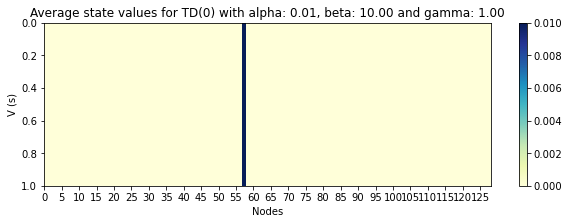

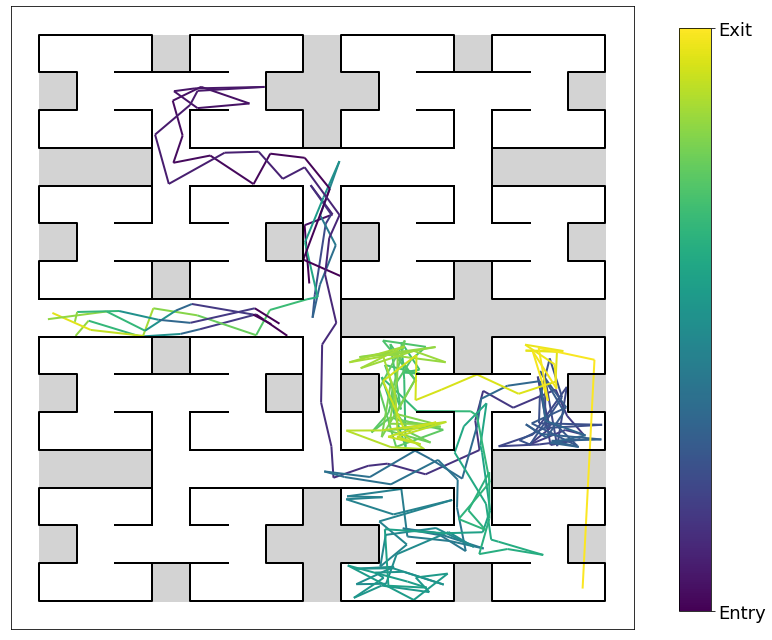

In [8]:
# Define TD(0) model
'''
Toy TD(0) model to simulate trajectories with

Returns: state_hist_all, dictionary of trajectories most recently simulated by the model. 
         If avg_count > 1, state_hist_all represents the latest simulation results
         Type: state_hist_all{0:[0,1,3..], 1:[]..}
         
         avg_V, average state-values resulting from simulation.
         Type: ndarray[(1,S), float]
'''
# np.random.seed(0)
# Set environment parameters
rl_model = BaseModel()
nodemap = rl_model.get_SAnodemap()
# nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states

# Set model parameters
alpha = 0.01  # learning rate
gamma = 1
beta = 10  # softmax exploration - exploitation
N = 5  # number of episodes to train over
speed = 10  # mice speed in nodes per sec
timeout = 10  # units of seconds that the reward port times out

# Simulation settings
avg_count = 1  # Number of times to repeat the simulation. Only state-values will be averaged, avg_V
avg_V = np.zeros(S)


for count in np.arange(avg_count):
    # Initialize model parameters
    V = np.zeros(S) #np.random.rand(S)  # state-action values
    V[HomeNode] = 0  # setting action-values of maze entry to 0
    V[RewardNode] = 0  # setting action-values of reward port to 0
    state_hist_all = {}
    total_reward = 0
    t = timeout

    for n in np.arange(N):
        # Initialize starting state,s0 to node 0
        s = 0
        state_hist = []
        print(n)
        
        step_count=0
        # Begin episode
        while s!=HomeNode and step_count<=100000: #and s!=RewardNode:
            # Record current state
            state_hist.extend([s])

            # Use softmax policy to select action, a at current state, s
            a, _ = softmax(s, V, beta)

            # Observe reward and next state based on selected action
            sprime = int(nodemap[s,a])
            if sprime == RewardNode and t >= timeout:
                R = RewardNodeMag  # Receive a reward of 1 when transitioning to the reward port
                total_reward += 1
                t = 0  # Reset timer
            else:
                R = 0
                t += speed  # Increment time from last reward

            # Update action-value of previous state value, V[s]
            V[s] += alpha * (R + gamma*V[sprime] - V[s])

            # Shift state values for the next time step
            s = sprime
            step_count+=1
            if step_count%100==0:
                print(step_count)
                print("action ", a, 'state ', s)
        if step_count>100000:
            print("didn't reach home")
        state_hist.extend([s])
        state_hist_all[n] = state_hist

    avg_V += deepcopy(V)
avg_V /= avg_count

print('alpha: ', alpha, ' beta: ', beta, ' gamma: ', gamma)
visualize_pred(avg_V, state_hist_all)

### TD($\lambda$)

 - States: 128 maze nodes (including home node)
 - Terminal states: maze entry, 127 and reward port, 116
 - Rewards: 0 on all states except for 1 on the water port
 
 Pseudocode
- Softmax action selection policy: $\pi(a | s_i) = \frac{e^{\beta*V(s_{ij})}}{e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})}}$, where j indexes the 3 neighboring nodes to $s_i$
- Temporal difference error: $\delta = R + \gamma*V(s') - V(s)$
- Eligibility trace: $e(s) \leftarrow e(s) + 1$
- State-value update: $V(s) \leftarrow V(s) + \alpha*(\delta)*e(s)$        [all state-values are updated at each step]
- Eligibility trace decay: $e(s) \leftarrow \gamma*\lambda*e(s)$           [eligibility traces of all states are decayed at each step]

In [ ]:
# Define TD(lambda) model
'''
Toy TD(lambda) model to predict trajectories

Returns: state_hist_all, dictionary of trajectories most recently simulated by the model. 
         If avg_count > 1, state_hist_all represents the latest simulation results
         Type: state_hist_all{0:[0,1,3..], 1:[]..}
         
         avg_V, average state-values resulting from simulation.
         Type: ndarray[(1,S), float]
'''

# Set environment parameters
nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states

# Set model parameters
alpha = 0.1   # learning rate, 0 < alpha < 1
beta = 10      # softmax exploration - exploitation
gamma = 1      # degree of discounting future state values, 0 < gamma < 1 
lamda = 0.5    # extent of past states to update, 0 < lambda < 1
N = 10          # number of episodes to train over
#speed = 10  # mice speed in nodes per sec
#timeout = 10  # units of seconds that the reward port times out

# Simulation settings
avg_count = 1  # Number of times to repeat the simulation. Only state-values will be averaged, avg_V
avg_V = np.zeros(S)

for count in np.arange(avg_count):
    # Initialize model parameters
    V = np.zeros(S)    # state values
    V[HomeNode] = 0    # setting state-values of maze entry to 0
    V[RewardNode] = 0  # setting state-values of reward port to 0
    e = np.zeros(S)    # eligibility trace vector for all states
    state_hist_all = {}
    #t = timeout

    for n in np.arange(N):
        # Initialize starting state,s0 to node 0
        s = 0
        state_hist = []

        # Begin episode
        while s!=HomeNode and s!=RewardNode:
            # Record current state
            state_hist.extend([s])

            # Use softmax policy to select action, a at current state, s
            betaV = []
            for node in nodemap[s,:]:
                if node==InvalidState:
                    betaV.extend([0])
                else:
                    betaV.extend([np.exp(beta*V[node])])
            prob = betaV/np.sum(betaV)
            try:
                a = np.random.choice([0,1,2],1,p=prob)[0]
            except ValueError:
                print('Error with aprob')
                print('Current state: ', s, 'Potential future states: ', nodemap[s,:], ' prob: ', prob)

            # Observe reward and next state based on selected action
            sprime = nodemap[s,a]
            if sprime == RewardNode: #and t >= timeout:
                R = RewardNodeMag  # Receive a reward of 1 when transitioning to the reward port
                #t = 0  # Reset timer
            else:
                R = 0
                #t += speed  # Increment time from last reward

            # Calculate error signal for current state
            td_error = R + gamma*V[sprime] - V[s]
            e[s] += 1
            
            # Propagate value to all other states
            for node in np.arange(S):
                V[node] += alpha * td_error * e[node]
                e[node] = gamma * lamda * e[node]

            # Update future state to current state
            s = sprime
            
        state_hist.extend([s])
        state_hist_all[n] = state_hist

    avg_V += deepcopy(V)
avg_V /= avg_count

print('alpha: ', alpha, ' beta: ', beta, ' gamma: ', gamma, 'lambda: ', lamda)
visualize_pred(avg_V, state_hist_all)